In [2]:
# (Opsional) Pastikan versi libs cukup baru
!pip install -q pyyaml pandas numpy matplotlib seaborn pillow tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Dataset13_Trofes.v1-trofes_dataset_30classv2.yolov8.zip"  # <— ganti jika beda folder
!mkdir -p /content/dataset
!unzip -q -o "$zip_path" -d /content/dataset
!ls -R /content/dataset | head -n 200

Mounted at /content/drive
/content/dataset:
data.yaml
README.roboflow.txt
test
train
valid

/content/dataset/test:
images
labels

/content/dataset/test/images:
00000005_jpg.rf.59f80f83710ee4e1adb5db2a1cb8da93.jpg
00000008_jpg.rf.742be0ccbd17a6f3a609a4cfc621fd4e.jpg
00000017_jpg.rf.8e801498b1368c5f25ee17b25776d025.jpg
00000022_jpg.rf.5849269ce2703df6115064054f094132.jpg
00000024_jpg.rf.af7b23b791c9247e11c754838b9a8bb7.jpg
00000028_jpg.rf.c6f7fd9afa0c3d66a0d3abc48b6b7fb5.jpg
00000035_jpg.rf.52c7c7dd62b2d677c131599941058f54.jpg
00000036_jpg.rf.692361739ca247af19e33134cc502db7.jpg
00000038_jpg.rf.400cf3daf1f52c0f2a5b9071ec2b20b2.jpg
00000039_jpg.rf.9dbc0469879b99f74cefb54644ec94b5.jpg
00000042_jpg.rf.aa60cfa6704ce630f6c0ee93f79b10a9.jpg
00000053_jpg.rf.cc6accde19ddc21d7562463748c0be73.jpg
00000055_jpg.rf.5e20c626ddd3ca17c33ef05be43b760a.jpg
00000066_jpg.rf.6c652cbd259c5847bca0262cab879f6d.jpg
00000071_jpg.rf.3e81eda4ab1b4117ff982ef201407895.jpg
00000073_jpg.rf.6e616b73f728b5f372212a5e1eb46

In [4]:
DATASET_DIR = "/content/dataset/Dataset13_Trofes.v1-trofes_dataset_30classv2.yolov8"

In [5]:
import os
import glob
import hashlib
import yaml
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [6]:
!ls /content/dataset

data.yaml  README.roboflow.txt	test  train  valid


In [7]:
# ========= IMPORT =========
import os
import glob
import yaml

# ========= UTILS =========
def load_yaml(path):
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

# ========= CONFIG =========
DATASET_DIR = "/content/dataset"
DATA_YAML = os.path.join(DATASET_DIR, "data.yaml")
OUTDIR = "eda_outputs"
os.makedirs(OUTDIR, exist_ok=True)


# --- Tambahkan fungsi helper untuk deteksi split yang tersedia ---
def detect_splits(base):
    # Pola A: base/images/split
    candidates = []
    for s in ["train", "val", "valid", "test"]:
        if os.path.isdir(os.path.join(base, "images", s)):
            candidates.append(s)
    if candidates:
        return [("val" if s == "valid" else s) for s in candidates]

    # Pola B: base/split/images (Roboflow)
    candidates = []
    for s in ["train", "val", "valid", "test"]:
        if os.path.isdir(os.path.join(base, s, "images")):
            candidates.append(s)
    if candidates:
        return [("val" if s == "valid" else s) for s in candidates]

    return ["train", "val"]

# --- Modifikasi list_pairs agar mendukung dua pola struktur ---
def list_pairs(split):
    real_split = "valid" if split == "val" and os.path.isdir(os.path.join(DATASET_DIR, "valid")) else split

    # Pola A
    img_dir_A = os.path.join(DATASET_DIR, "images", real_split)
    lbl_dir_A = os.path.join(DATASET_DIR, "labels", real_split)

    # Pola B (Roboflow)
    img_dir_B = os.path.join(DATASET_DIR, real_split, "images")
    lbl_dir_B = os.path.join(DATASET_DIR, real_split, "labels")

    if os.path.isdir(img_dir_A) and os.path.isdir(lbl_dir_A):
        img_dir = img_dir_A
        replace_from = os.path.sep + "images" + os.path.sep
        replace_to = os.path.sep + "labels" + os.path.sep
    elif os.path.isdir(img_dir_B) and os.path.isdir(lbl_dir_B):
        img_dir = img_dir_B
        replace_from = os.path.sep + real_split + os.path.sep + "images" + os.path.sep
        replace_to = os.path.sep + real_split + os.path.sep + "labels" + os.path.sep
    else:
        return []

    exts = ("*.jpg", "*.jpeg", "*.png")
    imgs = []
    for e in exts:
        imgs.extend(glob.glob(os.path.join(img_dir, "**", e), recursive=True))

    pairs = []
    for ip in imgs:
        lp = os.path.splitext(ip.replace(replace_from, replace_to))[0] + ".txt"
        pairs.append((ip, lp))
    return pairs

# ========= LOAD YAML & DETEKSI SPLIT =========
cfg = load_yaml(DATA_YAML)

names = cfg.get("names", [])
nc = cfg.get("nc", len(names))
if not names or len(names) != nc:
    names = [f"class_{i}" for i in range(nc)]

available_splits = detect_splits(DATASET_DIR)
available_splits = [("val" if s == "valid" else s) for s in available_splits]

order = ["train", "val", "test"]
splits = [s for s in order if s in available_splits]
if not splits:
    splits = ["train", "val"]

print("✅ Splits terdeteksi:", splits)
print("✅ Jumlah kelas:", nc)
print("✅ Nama kelas:", names)

✅ Splits terdeteksi: ['train', 'val', 'test']
✅ Jumlah kelas: 30
✅ Nama kelas: ['apple', 'banana', 'beef', 'bell pepper', 'cabbage', 'carrot', 'chicken', 'chili', 'crab', 'egg', 'eggplant', 'garlic', 'ginger', 'jalapeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'mushroom', 'onion', 'oyster', 'pea', 'pork', 'potato', 'rice', 'salmon', 'shrimp', 'spinach', 'tofu', 'tomato']


In [27]:
# show the data distribution each class in the train, val, and test folder
from collections import Counter
import pandas as pd
import os

def get_label_dir(split):
    # mapping 'val' -> 'valid' (Roboflow)
    if split == "val":
        split = "valid"
    return os.path.join(DATASET_DIR, split, "labels")

splits = ["train", "val", "test"]

# hitung per split
split_class_counts = {s: Counter() for s in splits}

for s in splits:
    label_dir = get_label_dir(s)
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    cls_id = int(line.split()[0])
                    split_class_counts[s][cls_id] += 1

# jadikan DataFrame (baris=kelas, kolom=split)
df_dist = pd.DataFrame({
    "class": names,
    "train": [split_class_counts["train"][i] for i in range(len(names))],
    "val":   [split_class_counts["val"][i]   for i in range(len(names))],
    "test":  [split_class_counts["test"][i]  for i in range(len(names))],
})

df_dist

,class,train,val,test
0,apple,833,191,150
1,banana,852,7,218
2,beef,898,87,106
3,bell pepper,823,132,137
4,cabbage,734,77,112
5,carrot,865,96,80
6,chicken,682,145,179
7,chili,834,0,16
8,crab,910,121,132
9,egg,648,85,192


In [9]:
import os

def get_image_dir(split):
    # mapping internal 'val' -> folder asli 'valid' (Roboflow)
    if split == "val":
        split = "valid"
    return os.path.join(DATASET_DIR, split, "images")

In [10]:
def count_images(split):
    img_dir = get_image_dir(split)
    return len([
        f for f in os.listdir(img_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ])

In [11]:
img_counts = {}
for split in splits:
    img_counts[split] = count_images(split)

img_counts

{'train': 9407, 'val': 1186, 'test': 1187}

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

def get_label_dir(split):
    # mapping internal 'val' -> folder asli 'valid'
    if split == "val":
        split = "valid"
    return os.path.join(DATASET_DIR, split, "labels")

In [13]:
def objects_per_image(split):
    label_dir = get_label_dir(split)
    counts = []

    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                counts.append(len(f.readlines()))

    return counts

In [14]:
obj_counts = {}

for split in splits:
    obj_counts[split] = objects_per_image(split)
    print(
        f"{split}: "
        f"rata-rata = {np.mean(obj_counts[split]):.2f}, "
        f"maksimum = {np.max(obj_counts[split])}"
    )

train: rata-rata = 2.67, maksimum = 221
val: rata-rata = 2.18, maksimum = 44
test: rata-rata = 2.35, maksimum = 121


Analisis jumlah objek per gambar menunjukkan bahwa rata‑rata setiap gambar mengandung 2–3 objek, yang menandakan mayoritas citra memiliki kompleksitas rendah hingga sedang.
Namun demikian, ditemukan beberapa gambar dengan jumlah objek yang sangat tinggi, terutama pada data training dengan maksimum mencapai 221 objek per gambar. Hal ini mengindikasikan keberadaan citra dengan kepadatan objek yang tinggi, yang berpotensi memengaruhi proses pelatihan model. Oleh karena itu, diperlukan analisis lanjutan terhadap distribusi ukuran bounding box dan distribusi kelas untuk memastikan stabilitas pelatihan model YOLOv8.

In [15]:
bbox_areas = []

for split in splits:
    label_dir = get_label_dir(split)
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    parts = line.split()
                    if len(parts) >= 5:
                        w = float(parts[3])
                        h = float(parts[4])
                        bbox_areas.append(w * h)

bbox_areas = np.array(bbox_areas)

In [16]:
print("Rata-rata area bbox:", bbox_areas.mean())
print("Median area bbox:", np.median(bbox_areas))
print("Persentase small object (<0.01):", np.mean(bbox_areas < 0.01))

Rata-rata area bbox: 0.22843016075892952
Median area bbox: 0.1585384893147992
Persentase small object (<0.01): 0.08213794458636274


######Analisis distribusi ukuran bounding box menunjukkan bahwa mayoritas objek dalam dataset memiliki ukuran sedang hingga besar. Nilai median luas bounding box sebesar 0.158 dan rata‑rata sebesar 0.228 menunjukkan distribusi yang relatif seimbang tanpa dominasi objek berukuran sangat kecil.
Persentase small object (luas < 0.01) hanya sekitar 8%, yang mengindikasikan bahwa sebagian besar objek memiliki ukuran yang cukup representatif di dalam citra. Temuan ini menjelaskan keberadaan gambar dengan jumlah objek yang sangat tinggi, di mana satu citra dapat mengandung banyak objek berukuran sedang, bukan karena objek terlalu kecil atau kesalahan anotasi.

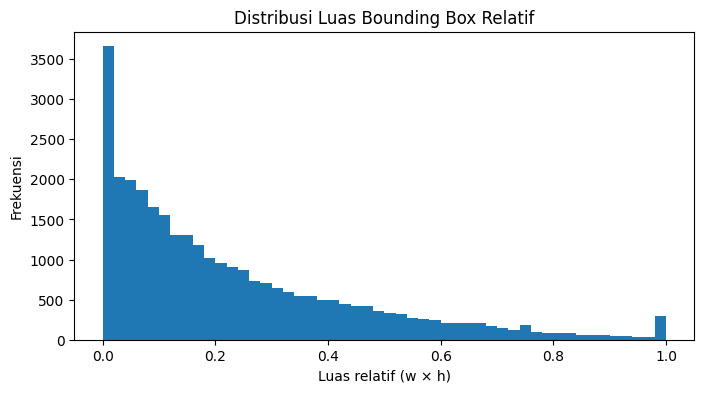

In [17]:
plt.figure(figsize=(8,4))
plt.hist(bbox_areas, bins=50)
plt.title("Distribusi Luas Bounding Box Relatif")
plt.xlabel("Luas relatif (w × h)")
plt.ylabel("Frekuensi")
plt.show()

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

class_counts = Counter()

for split in splits:
    label_dir = get_label_dir(split)
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    cls_id = int(line.split()[0])
                    class_counts[cls_id] += 1

# Ubah ke list terurut sesuai id kelas
counts = [class_counts[i] for i in range(len(names))]

for i, c in enumerate(counts):
    print(f"{names[i]:<12}: {c}")

apple       : 1174
banana      : 1077
beef        : 1091
bell pepper : 1092
cabbage     : 923
carrot      : 1041
chicken     : 1006
chili       : 850
crab        : 1163
egg         : 925
eggplant    : 1058
garlic      : 1156
ginger      : 846
jalapeno    : 1015
kiwi        : 1132
lemon       : 1090
lettuce     : 964
mango       : 1159
mushroom    : 820
onion       : 1169
oyster      : 1079
pea         : 1147
pork        : 952
potato      : 1158
rice        : 990
salmon      : 997
shrimp      : 1007
spinach     : 494
tofu        : 1144
tomato      : 815


In [19]:
import numpy as np
import matplotlib.pyplot as plt

x_centers = []
y_centers = []

for split in splits:
    label_dir = get_label_dir(split)
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    parts = line.split()
                    if len(parts) >= 5:
                        x_centers.append(float(parts[1]))
                        y_centers.append(float(parts[2]))

x_centers = np.array(x_centers)
y_centers = np.array(y_centers)

print("Total bbox dianalisis:", len(x_centers))

Total bbox dianalisis: 30534


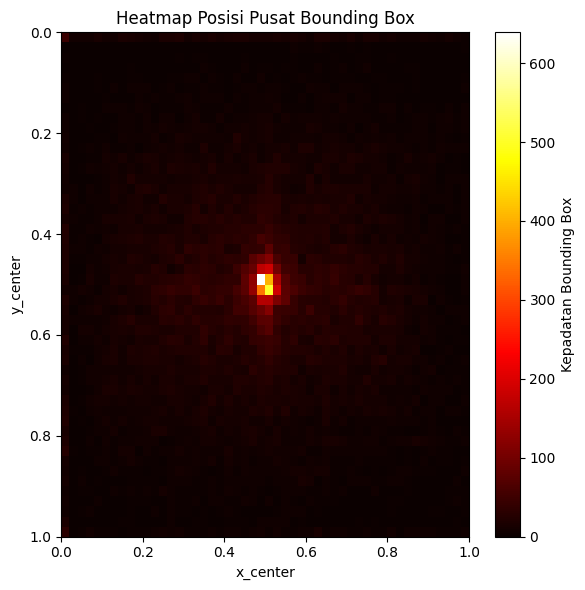

In [20]:
plt.figure(figsize=(6,6))
plt.hist2d(
    x_centers,
    y_centers,
    bins=50,
    range=[[0,1],[0,1]],
    cmap="hot"
)
plt.colorbar(label="Kepadatan Bounding Box")
plt.title("Heatmap Posisi Pusat Bounding Box")
plt.xlabel("x_center")
plt.ylabel("y_center")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Heatmap posisi pusat bounding box menunjukkan bahwa sebagian besar objek pada dataset terdistribusi di area tengah citra, dengan konsentrasi kepadatan tertinggi di sekitar titik (0.5, 0.5). Hal ini mengindikasikan adanya kecenderungan center bias, di mana objek lebih sering ditempatkan di tengah frame.
Meskipun demikian, sebaran bounding box tetap ditemukan di berbagai area citra dan tidak terfokus pada satu sisi tertentu, sehingga dataset masih merepresentasikan variasi posisi objek yang wajar. Pola ini umum dijumpai pada dataset makanan dan tidak dianggap sebagai bias ekstrem yang dapat mengganggu proses pelatihan model YOLOv8.


In [21]:
missing_labels = []
empty_labels = []

for split in splits:
    img_dir = get_image_dir(split)
    label_dir = get_label_dir(split)

    for img in os.listdir(img_dir):
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            label_name = os.path.splitext(img)[0] + ".txt"
            label_path = os.path.join(label_dir, label_name)

            if not os.path.exists(label_path):
                missing_labels.append((split, img))
            else:
                if os.path.getsize(label_path) == 0:
                    empty_labels.append((split, img))

print("Jumlah label hilang :", len(missing_labels))
print("Jumlah label kosong :", len(empty_labels))

Jumlah label hilang : 0
Jumlah label kosong : 0


In [22]:
invalid_bboxes = []

for split in splits:
    label_dir = get_label_dir(split)

    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line_num, line in enumerate(f):
                    parts = line.strip().split()

                    # Lewati baris kosong
                    if len(parts) < 5:
                        invalid_bboxes.append((split, file, line_num, "too_few_columns"))
                        continue

                    try:
                        cls = int(parts[0])
                        xc, yc, w, h = map(float, parts[1:5])
                    except:
                        invalid_bboxes.append((split, file, line_num, "parse_error"))
                        continue

                    # Validasi nilai YOLO
                    if not (0 <= xc <= 1 and 0 <= yc <= 1):
                        invalid_bboxes.append((split, file, line_num, "center_out_of_range"))
                    if w <= 0 or h <= 0 or w > 1 or h > 1:
                        invalid_bboxes.append((split, file, line_num, "size_invalid"))

print("Jumlah bbox tidak valid:", len(invalid_bboxes))

Jumlah bbox tidak valid: 43


In [23]:
invalid_class_ids = []

num_classes = len(names)

for split in splits:
    label_dir = get_label_dir(split)
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line_num, line in enumerate(f):
                    cls_id = int(line.split()[0])
                    if cls_id < 0 or cls_id >= num_classes:
                        invalid_class_ids.append((split, file, line_num, cls_id))

print("Jumlah class_id tidak valid:", len(invalid_class_ids))

Jumlah class_id tidak valid: 0


In [28]:
import os
import hashlib

def find_duplicates_in_train(train_img_dir):
    hash_map = {}
    duplicates = []

    for img in os.listdir(train_img_dir):
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(train_img_dir, img)
            with open(path, "rb") as f:
                h = hashlib.md5(f.read()).hexdigest()

            if h in hash_map:
                duplicates.append((hash_map[h], img))
            else:
                hash_map[h] = img

    return duplicates

train_img_dir = os.path.join(DATASET_DIR, "train", "images")
train_duplicates = find_duplicates_in_train(train_img_dir)

print("Jumlah duplicate di train:", len(train_duplicates))
train_duplicates[:10]  # contoh 10 pertama

Jumlah duplicate di train: 295


[('download-3-_augmented_1_jpg.rf.4ccc7d516efe49095414d16bd6e2164a.jpg',
  'download-3-_augmented_1_jpg.rf.a389c628d9447ea536a3b192bde38510.jpg'),
 ('istockphoto-1145007536-612x612_jpg.rf.02eaf5de5c5027bf857729ed4b78fb32.jpg',
  'istockphoto-1145007536-612x612_jpg.rf.5822e05ba31a8f5cd07ab142b70b469c.jpg'),
 ('A250101XX_10499_jpg.rf.b179136611ae8cad2cdeab4e3cfd0dbf.jpg',
  'A250101XX_10499_jpg.rf.193f40e07e82f5c37ce0160874644f72.jpg'),
 ('tof_24_png.rf.51109869cd23570af2f9466fce11d34c.jpg',
  'dubu-27-_jpg.rf.2dc66b1287120cb4b9eebd8de9a4006d.jpg'),
 ('A250101XX_11597_jpg.rf.3de92af49c34988d77c4fcb943109c4f.jpg',
  'A250101XX_11597_jpg.rf.d2cb6743a5ea0172bcb59e97a2ab513e.jpg'),
 ('download-1-_augmented_1_jpg.rf.c1a79be7f519fd04895eb7efa0ae4a5d.jpg',
  'download-1-_augmented_1_jpg.rf.be41a89965cc9568d88eca9882da708d.jpg'),
 ('download-19-_augmented_2_jpg.rf.d381452946150698e89fc4289fc02ebc.jpg',
  'download-19-_augmented_2_jpg.rf.6c5de2896a2797813de90d47e67f90dc.jpg'),
 ('dubu-94-_jpg.rf.

Ditemukan sejumlah gambar duplikat pada subset training yang berasal dari hasil augmentasi offline. Duplikasi ini tidak memengaruhi validitas evaluasi model karena tidak terjadi pada subset validation maupun testing.

In [24]:
import hashlib

hash_map = {}
duplicates = []

for split in splits:
    img_dir = get_image_dir(split)
    for img in os.listdir(img_dir):
        if img.lower().endswith((".jpg",".png",".jpeg")):
            path = os.path.join(img_dir, img)
            with open(path, "rb") as f:
                h = hashlib.md5(f.read()).hexdigest()

            if h in hash_map:
                duplicates.append((hash_map[h], (split, img)))
            else:
                hash_map[h] = (split, img)

print("Jumlah gambar duplikat:", len(duplicates))

Jumlah gambar duplikat: 366


In [25]:
cross_split_dups = []

for (split1, img1), (split2, img2) in duplicates:
    if split1 != split2:
        cross_split_dups.append((split1, img1, split2, img2))

print("Duplikat lintas split:", len(cross_split_dups))

Duplikat lintas split: 71


#preprocessing


In [26]:
for split1, img1, split2, img2 in cross_split_dups:
    # hapus dari val & test, jangan dari train
    if split1 != "train":
        os.remove(os.path.join(get_image_dir(split1), img1))
    elif split2 != "train":
        os.remove(os.path.join(get_image_dir(split2), img2))


Pemeriksaan duplikasi gambar menunjukkan adanya 71 gambar duplikat lintas subset dataset. Untuk mencegah terjadinya data leakage, duplikasi tersebut ditangani dengan memastikan bahwa gambar identik hanya terdapat pada subset training, sementara subset validation dan testing bersifat unik. Setelah proses ini, dataset dinilai layak digunakan untuk evaluasi performa model secara objektif dan adil.

Tahap preprocessing dataset meliputi validasi format anotasi YOLO, pembersihan data dari duplikasi lintas subset untuk mencegah data leakage, serta pemeriksaan kualitas bounding box. Seluruh gambar dan anotasi kemudian diproses menggunakan mekanisme preprocessing bawaan YOLOv8, termasuk resize dengan letterbox, normalisasi nilai piksel, dan augmentasi data. Augmentasi data digunakan untuk meningkatkan variasi data latih serta mengurangi potensi bias posisi objek dan ketidakseimbangan kelas ringan yang teridentifikasi pada tahap EDA.

Dataset terlebih dahulu melalui tahap preprocessing menggunakan platform Roboflow, termasuk penyesuaian resolusi gambar menjadi 640×640. Selanjutnya dilakukan Exploratory Data Analysis (EDA) untuk menganalisis distribusi kelas, jumlah objek per gambar, ukuran bounding box, serta kualitas anotasi.

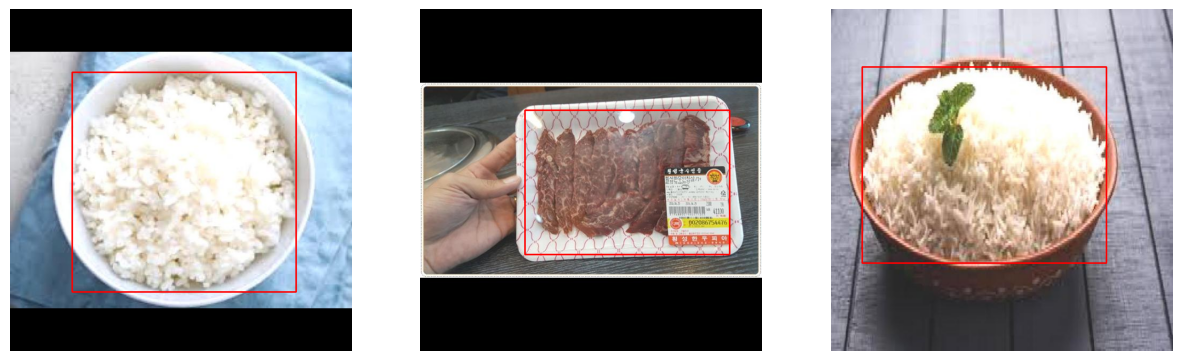

In [34]:
import cv2
import matplotlib.pyplot as plt
import random

def plot_random_sample(split='train', n=3):
    img_dir = get_image_dir(split)
    lbl_dir = get_label_dir(split)
    imgs = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    plt.figure(figsize=(15, 5))
    for i in range(n):
        img_path = os.path.join(img_dir, random.choice(imgs))
        lbl_path = os.path.join(lbl_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    cls, xc, yc, nw, nh = map(float, line.split())
                    # Convert YOLO format to pixel coordinates
                    x1 = int((xc - nw/2) * w)
                    y1 = int((yc - nh/2) * h)
                    x2 = int((xc + nw/2) * w)
                    y2 = int((yc + nh/2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

plot_random_sample()

In [32]:
def normalize_yolo(size, box):
    """
    size: (width, height) gambar asli
    box: [xmin, ymin, xmax, ymax] dalam piksel
    """
    dw = 1. / size[0]
    dh = 1. / size[1]

    # Hitung titik pusat
    x_center = (box[0] + box[2]) / 2.0
    y_center = (box[1] + box[3]) / 2.0

    # Hitung lebar dan tinggi
    w = box[2] - box[0]
    h = box[3] - box[1]

    # Normalisasi
    x_center = x_center * dw
    y_center = y_center * dh
    w = w * dw
    h = h * dh

    return (x_center, y_center, w, h)

# Contoh Penggunaan:
img_width, img_height = 640, 480
pixel_box = [100, 150, 300, 400] # [xmin, ymin, xmax, ymax]

yolo_box = normalize_yolo((img_width, img_height), pixel_box)
print(f"Format YOLO (Normalized): {yolo_box}")
# Output: (0.3125, 0.5729, 0.3125, 0.5208)

Format YOLO (Normalized): (0.3125, 0.5729166666666666, 0.3125, 0.5208333333333334)


x_center (0.3125): Pusat objek berada di 31.25% dari lebar gambar (dihitung dari kiri).

y_center (0.5729): Pusat objek berada di 57.29% dari tinggi gambar (dihitung dari atas).

width (0.3125): Lebar kotak objek adalah 31.25% dari total lebar gambar.

height (0.5208): Tinggi kotak objek adalah 52.08% dari total tinggi gambar.

Seluruh label telah melalui tahap Normalisasi Spasial. Hal ini menjamin bahwa model YOLOv8 dapat mempelajari fitur objek secara konsisten meskipun terdapat variasi resolusi pada data asli, serta menjaga stabilitas perhitungan loss function selama proses training